In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
from sklearn.neighbors import BallTree
from sklearn.linear_model import LinearRegression

In [6]:
ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
gdf = gpd.read_file('Data\stations.geojson').to_crs(ibge.crs)
df_cerrado = pd.read_pickle(r'D:\GU\IC\Scripts\Data\df_cerrado_bet.pkl')
gdf_filtered = gdf[gdf.Code.isin(df_cerrado.Code.unique())]

In [9]:
df_bet = pd.read_pickle('D:\GU\IC\Scripts\Data\ANA_81_10_bet.pkl')
gdf_bet = gdf[gdf.Code.isin(df_bet.Code.unique())]
gdf_bet.reset_index(drop=True, inplace=True)


In [13]:
df_all = pd.read_pickle(r'Data\ANA_clean.pkl').dropna()
df_all = df_all.sort_values(by=['Code', 'Date', 'Consistency']).drop_duplicates(subset=['Code', 'Date'], keep='last')
gdf.sort_values(by='Code', inplace=True)
df_all.sort_values(by='Code', inplace=True)
gdf = gdf[gdf.Code.isin(df_all.Code.unique())]
gdf.reset_index(drop=True, inplace=True)
gdf['begin'] = df_all.sort_values('Date').groupby('Code').first().reset_index().sort_values('Code')['Date']
gdf['end'] = df_all.sort_values('Date').groupby('Code').last().reset_index().sort_values('Code')['Date']

In [7]:
def get_neighbors(src_points, candidates, k_neighbors):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=40, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    return indices, distances


def nearest_neighbors(left_gdf, right_gdf, k_neighbors=6):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    # Notice: should be in Lat/Lon format 
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
        
    closest, dist = get_neighbors(src_points=left_radians, candidates=right_radians, k_neighbors = k_neighbors)
        
    return closest

In [8]:
# create a df with this points, colums:latitude and longitude: (-2.85,-54.97), (-5.945, -22 )

points = [(-2.85,-54.97), (-3.37111111, -54.95111111),(-3.38916667,-54.95055556)]

# create a Pandas DataFrame with the points
df_tap = pd.DataFrame(points, columns=['latitude', 'longitude'])
df_tap


,latitude,longitude
0,-2.850000,-54.970000
1,-3.371111,-54.951111
2,-3.389167,-54.950556


In [103]:
#create a gdf from the df
gdf_tap = gpd.GeoDataFrame(df_tap, geometry=gpd.points_from_xy(df_tap.longitude, df_tap.latitude), crs=gdf.crs)


In [104]:
index_near = nearest_neighbors(gdf_tap.to_crs('EPSG:4326'), gdf.to_crs('EPSG:4326'), k_neighbors=5)

In [105]:
val = gdf.iloc[index_near[:, 0]]['Code'].values
gdf.iloc[index_near[:, 0]].drop(columns=['geometry'])

,Code,Name,Latitude,Longitude,Altitude,begin,end
228,254003,BELTERRA,-2.6333,-54.9500,176.0,1975-01-01,2007-12-01
231,254006,MOJU PRIMEIRO,-2.7333,-54.7667,80.0,1983-10-01,1984-10-01
234,254011,KM - 1707/BR 163,-2.6500,-54.8189,NaN,2004-11-01,2022-01-01
229,254004,SANTARÉM,-2.4167,-54.7833,60.0,1980-01-01,1985-12-01
225,254000,SANTARÉM,-2.4433,-54.7025,NaN,1968-05-01,2022-02-01


In [13]:
gdf.iloc[index_near[:, 2]].drop(columns=['geometry'])

,Code,Name,Latitude,Longitude,Altitude,begin,end
598,354002,KM 125 - ESTRADA SANTARÉM - CUIABÁ,-3.4000,-54.9000,100.0,1983-12-01,1984-10-01
600,355001,MUTUM,-3.4936,-54.8869,NaN,1999-07-01,2022-02-01
599,355000,FAZENDA DANIEL DE CARVALHO,-3.5833,-55.3667,NaN,1977-12-01,1983-01-01
597,354001,ACAMPAMENTO PILOTO,-3.3833,-54.4833,50.0,1983-12-01,1984-02-01
966,454001,FAZENDA MARCONDES,-3.9664,-54.6419,NaN,1982-05-01,2021-05-01


In [14]:
df_all[df_all.Code==454001].drop(columns=['Code', 'Consistency']).sort_values('Date').reset_index(drop=True).to_csv(r'Data\Deli\454001.csv', index=False)

In [21]:
dff = df_all[df_all.Code==254000].drop(columns=['Code', 'Consistency']).sort_values('Date')
#get data only in 2016
dff[dff.Date.dt.year==2016]

,Date,Total
2993556,2016-02-01,120.6
2993555,2016-03-01,342.4
2993553,2016-05-01,311.3
2993552,2016-06-01,165.8
2993551,2016-07-01,61.3
2993550,2016-08-01,18.3
2993548,2016-10-01,94.2
2993547,2016-11-01,35.4
2993546,2016-12-01,126.7


In [20]:
df_all[df_all.Code==254011].drop(columns=['Code', 'Consistency']).sort_values('Date').reset_index(drop=True).to_csv(r'Data\Deli\254011.csv', index=False)

In [15]:
df_all[df_all.Code==254000].drop(columns=['Code', 'Consistency']).sort_values('Date').reset_index(drop=True).to_csv(r'Data\Deli\254000.csv', index=False)

In [46]:
gdf.iloc[[225, 966]].drop(columns=['geometry']).to_csv(r'Data\Deli\stations.csv', index=False)

## CAIO

In [217]:
df_bet = pd.read_pickle('D:\GU\IC\Scripts\ANA_81_10_bet.pkl')
gdf = gpd.read_file('stations.geojson').to_crs(ibge.crs)
gdf_bet = gdf[gdf.Code.isin(df_bet.Code.unique())]
gdf_bet.reset_index(drop=True, inplace=True)


In [218]:
df_caio = pd.DataFrame({'Area': ['Reserva Ducke', 'FLONA Tapajós', 'Chapada dos Veadeiros'],
     'Latitude': [-2.953, -2.908, -14.110],
     'Longitude': [-59.933, -54.997, -47.647]})
gdf_caio = gpd.GeoDataFrame(df_caio, geometry=gpd.points_from_xy(df_caio.Longitude, df_caio.Latitude), crs=gdf.crs)

In [219]:
index_near = nearest_neighbors(gdf_caio.to_crs('EPSG:4326'), gdf_bet.to_crs('EPSG:4326'), k_neighbors=5)

In [220]:
gdf_bet.iloc[index_near[0, :]]['Code'].values

array([ 360000,  254000, 1447000], dtype=int64)

In [221]:
val = gdf_bet.iloc[index_near[0, :]]['Code'].values
gdf_caio['Code'] = val
gdf_caio = gdf_caio.merge(gdf_bet[gdf_bet.Code.isin(val)], on='Code', suffixes=('_area', '_station'))
gdf_caio

,Area,Latitude_area,Longitude_area,geometry_area,Code,Name,Latitude_station,Longitude_station,Altitude,geometry_station
0,Reserva Ducke,-2.953,-59.933,POINT (-59.93300 -2.95300),360000,MANAUS,-3.1167,-59.9500,67.0,POINT (-59.95000 -3.11670)
1,FLONA Tapajós,-2.908,-54.997,POINT (-54.99700 -2.90800),254000,SANTARÉM,-2.4433,-54.7025,NaN,POINT (-54.70250 -2.44330)
2,Chapada dos Veadeiros,-14.110,-47.647,POINT (-47.64700 -14.11000),1447000,ALTO PARAÍSO DE GOIÁS,-14.1347,-47.5117,1197.0,POINT (-47.51170 -14.13470)


In [222]:
df_caio = df_bet[df_bet.Code.isin(val)].reset_index(drop=True)
df_caio = df_caio.merge(gdf_caio[['Code', 'Name']], on=['Code'], how='left')

In [223]:
df_caio.to_csv(r'Data\Deli\df_caio_consist.csv', index=False)
gdf_caio.to_csv(r'Data\Deli\gdf_caio_consist.csv', index=False)


C:\Users\luisg\AppData\Local\Temp\ipykernel_25568\1463185758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_map = df_caio.groupby(['Code', df_caio.Date.dt.year]).sum().reset_index().merge(gdf_caio[['Code', 'Name']], on=['Code'], how='left')


<AxesSubplot: xlabel='Name', ylabel='Total'>

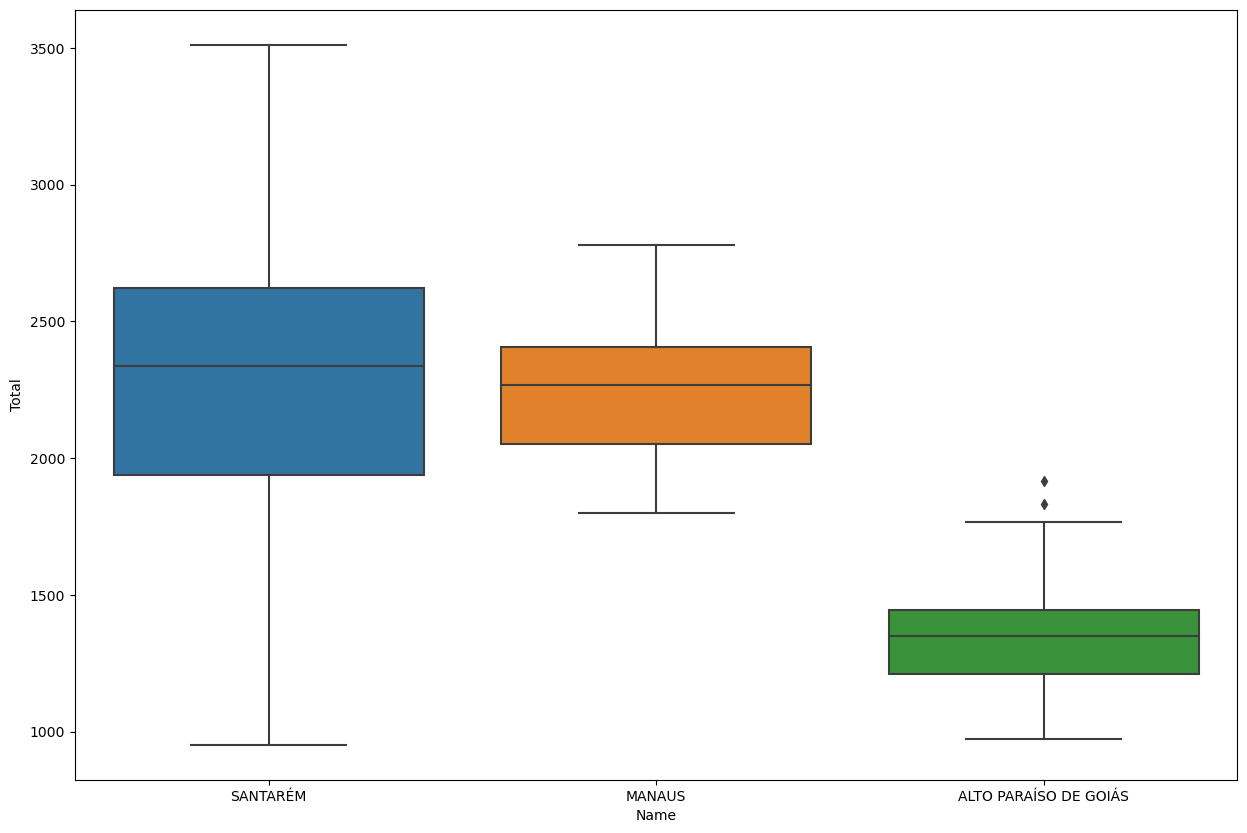

In [224]:
df_map = df_caio.groupby(['Code', df_caio.Date.dt.year]).sum().reset_index().merge(gdf_caio[['Code', 'Name']], on=['Code'], how='left')
#plot boxplot for each code
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='Name', y='Total', data=df_map, ax=ax)

<AxesSubplot: xlabel='Date', ylabel='Total'>

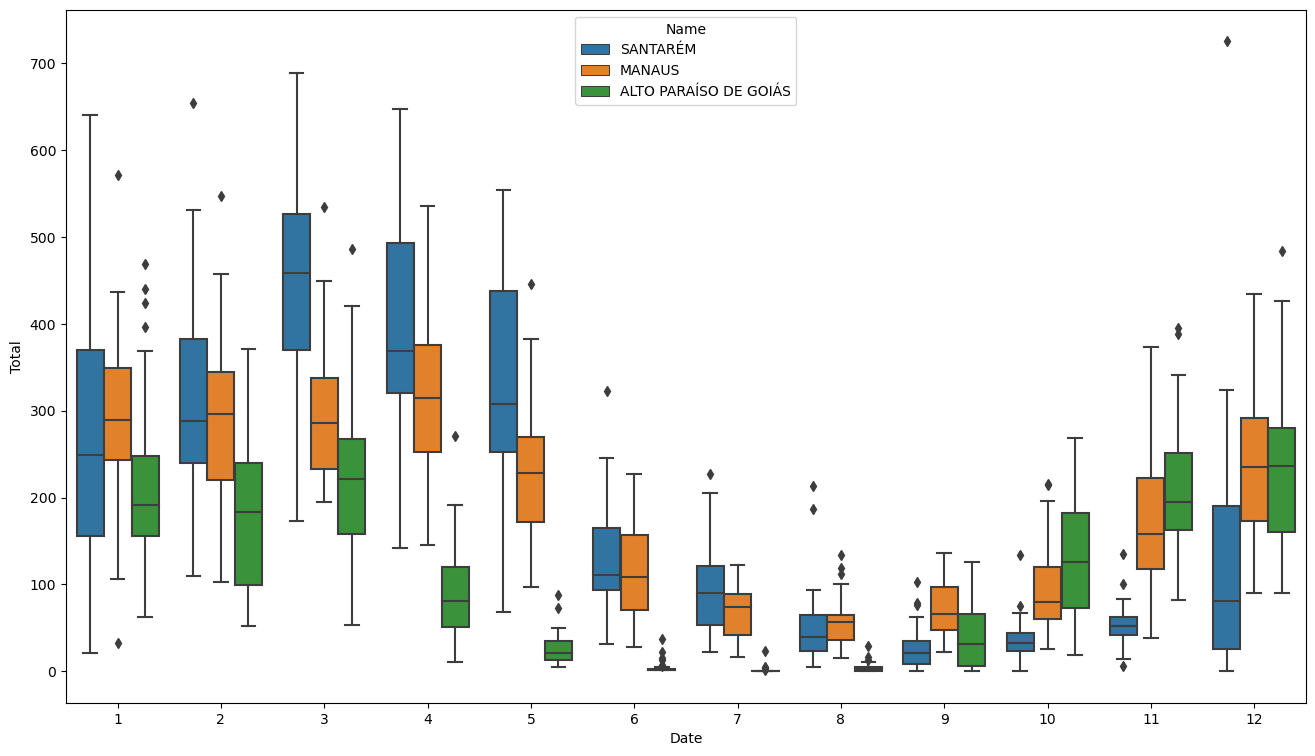

In [225]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(x=df_caio.Date.dt.month, y='Total', data=df_caio, hue='Name', ax=ax)

### all

In [226]:
df_all = pd.read_pickle('clean_all.pkl').dropna()
df_all = df_all.sort_values(by=['Code', 'Date', 'Consistency']).drop_duplicates(subset=['Code', 'Date'], keep='last')
gdf.sort_values(by='Code', inplace=True)
df_all.sort_values(by='Code', inplace=True)
gdf = gdf[gdf.Code.isin(df_all.Code.unique())]
gdf.reset_index(drop=True, inplace=True)
gdf['begin'] = df_all.sort_values('Date').groupby('Code').first().reset_index().sort_values('Code')['Date']
gdf['end'] = df_all.sort_values('Date').groupby('Code').last().reset_index().sort_values('Code')['Date']

In [227]:
df_caio = pd.DataFrame({'Area': ['Reserva Ducke', 'FLONA Tapajós', 'Chapada dos Veadeiros'],
     'Latitude': [-2.953, -2.908, -14.110],
     'Longitude': [-59.933, -54.997, -47.647]})
gdf_caio = gpd.GeoDataFrame(df_caio, geometry=gpd.points_from_xy(df_caio.Longitude, df_caio.Latitude), crs=gdf.crs)

In [228]:
index_near = nearest_neighbors(gdf_caio.to_crs('EPSG:4326'), gdf.to_crs('EPSG:4326'), k_neighbors=5)

In [229]:
# manaus 360000 , belterra 254003, chapada 1447000	

In [230]:
val = [360000, 254003, 1447000]
gdf[gdf.Code.isin(val)]

,Code,Name,Latitude,Longitude,Altitude,geometry,begin,end
228,254003,BELTERRA,-2.6333,-54.9500,176.0,POINT (-54.95000 -2.63330),1975-01-01,2007-12-01
620,360000,MANAUS,-3.1167,-59.9500,67.0,POINT (-59.95000 -3.11670),1961-01-01,2019-06-01
4401,1447000,ALTO PARAÍSO DE GOIÁS,-14.1347,-47.5117,1197.0,POINT (-47.51170 -14.13470),1969-01-01,2020-10-01


In [231]:
val = [360000, 254003, 1447000]
gdf_caio['Code'] = val
gdf_caio = gdf_caio.merge(gdf[gdf.Code.isin(val)], on='Code', suffixes=('_area', '_station'))
gdf_caio

,Area,Latitude_area,Longitude_area,geometry_area,Code,Name,Latitude_station,Longitude_station,Altitude,geometry_station,begin,end
0,Reserva Ducke,-2.953,-59.933,POINT (-59.93300 -2.95300),360000,MANAUS,-3.1167,-59.9500,67.0,POINT (-59.95000 -3.11670),1961-01-01,2019-06-01
1,FLONA Tapajós,-2.908,-54.997,POINT (-54.99700 -2.90800),254003,BELTERRA,-2.6333,-54.9500,176.0,POINT (-54.95000 -2.63330),1975-01-01,2007-12-01
2,Chapada dos Veadeiros,-14.110,-47.647,POINT (-47.64700 -14.11000),1447000,ALTO PARAÍSO DE GOIÁS,-14.1347,-47.5117,1197.0,POINT (-47.51170 -14.13470),1969-01-01,2020-10-01


In [232]:
df_caio = df_all[df_all.Code.isin(val)].reset_index(drop=True)
df_caio = df_caio.merge(gdf_caio[['Code', 'Name']], on=['Code'], how='left')

In [233]:
df_caio.to_csv(r'Data\Deli\df_caio_ANA.csv', index=False)
gdf_caio.to_csv(r'Data\Deli\gdf_ANA.csv', index=False)

C:\Users\luisg\AppData\Local\Temp\ipykernel_25568\1463185758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_map = df_caio.groupby(['Code', df_caio.Date.dt.year]).sum().reset_index().merge(gdf_caio[['Code', 'Name']], on=['Code'], how='left')


<AxesSubplot: xlabel='Name', ylabel='Total'>

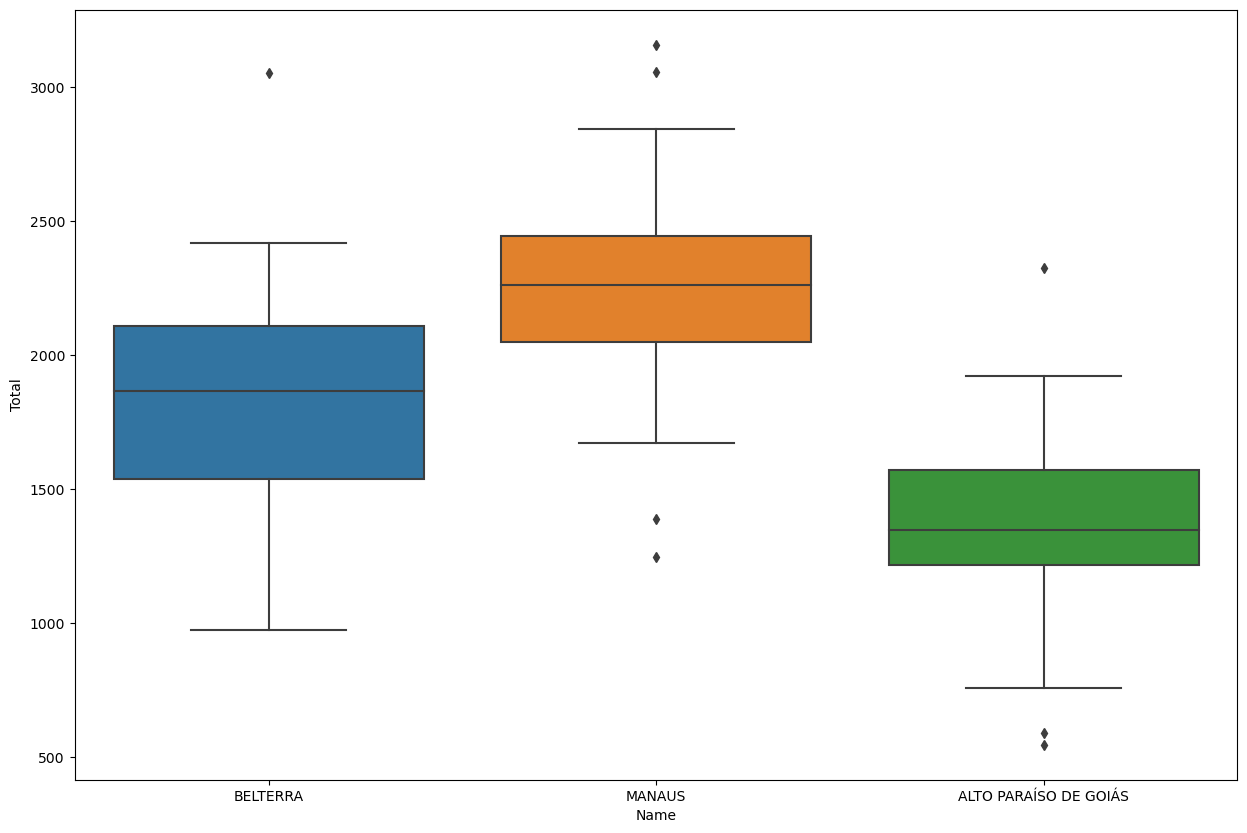

In [234]:
df_map = df_caio.groupby(['Code', df_caio.Date.dt.year]).sum().reset_index().merge(gdf_caio[['Code', 'Name']], on=['Code'], how='left')
#plot boxplot for each code
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='Name', y='Total', data=df_map, ax=ax)

<AxesSubplot: xlabel='Date', ylabel='Total'>

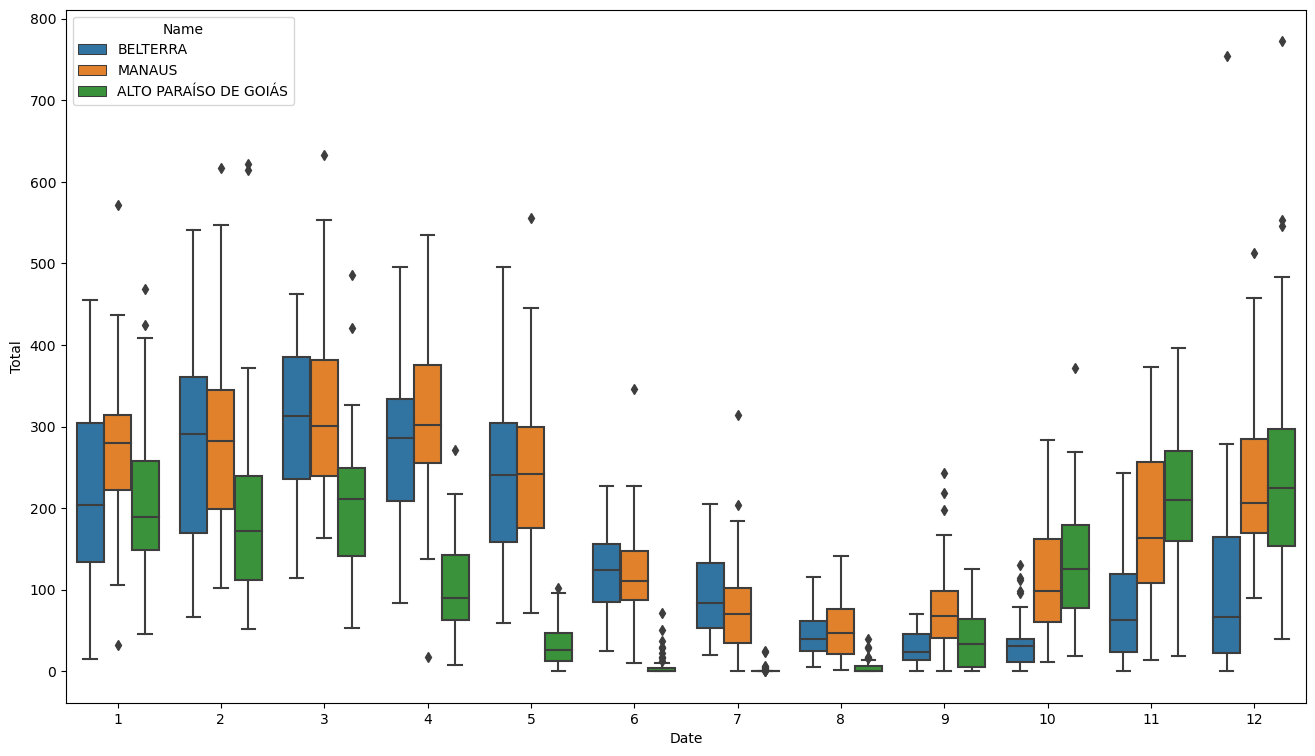

In [235]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(x=df_caio.Date.dt.month, y='Total', data=df_caio, hue='Name', ax=ax)

### VPD

In [236]:
frame_info = pd.read_csv('inmet_station.csv', index_col=0)
df_inmet = pd.read_pickle('inmet_all.pkl')
gdf_inmet = gpd.GeoDataFrame(frame_info, geometry=gpd.points_from_xy(frame_info.Longitude, frame_info.Latitude), crs=gdf.crs)
#change Code column to integer
df_inmet.Code = df_inmet.Code.astype(int)

In [237]:
gdf_inmet.sort_values(by='Code', inplace=True)
df_inmet.sort_values(by='Code', inplace=True)
gdf_inmet = gdf_inmet[gdf_inmet.Code.isin(df_inmet.Code.unique())]
gdf_inmet.reset_index(drop=True, inplace=True)
gdf_inmet['begin'] = df_inmet.sort_values('Date').groupby('Code').first().reset_index().sort_values('Code')['Date']
gdf_inmet['end'] = df_inmet.sort_values('Date').groupby('Code').last().reset_index().sort_values('Code')['Date']

In [238]:
df_caio = pd.DataFrame({'Area': ['Reserva Ducke', 'FLONA Tapajós', 'Chapada dos Veadeiros'],
     'Latitude': [-2.953, -2.908, -14.110],
     'Longitude': [-59.933, -54.997, -47.647]})
gdf_caio = gpd.GeoDataFrame(df_caio, geometry=gpd.points_from_xy(df_caio.Longitude, df_caio.Latitude), crs=gdf.crs)

In [239]:
index_near = nearest_neighbors(gdf_caio.to_crs('EPSG:4326'), gdf_inmet.to_crs('EPSG:4326'), k_neighbors=5)

In [240]:
val = gdf_inmet.iloc[index_near[0, :]]['Code'].values
gdf_caio['Code'] = val
gdf_caio = gdf_caio.merge(gdf_inmet[gdf_inmet.Code.isin(val)], on='Code', suffixes=('_area', '_station'))
gdf_caio.rename(columns={'Nome': 'Name'}, inplace=True)
gdf_caio

,Area,Latitude_area,Longitude_area,geometry_area,Code,Name,Latitude_station,Longitude_station,Altitude,geometry_station,begin,end
0,Reserva Ducke,-2.953,-59.933,POINT (-59.93300 -2.95300),82331,MANAUS,-3.103333,-60.016389,61.25,POINT (-60.01639 -3.10333),1981-01-01,2010-12-31
1,FLONA Tapajós,-2.908,-54.997,POINT (-54.99700 -2.90800),82246,BELTERRA,-2.642222,-54.943889,164.30,POINT (-54.94389 -2.64222),1981-01-01,2010-12-31
2,Chapada dos Veadeiros,-14.110,-47.647,POINT (-47.64700 -14.11000),83332,POSSE,-14.089167,-46.366667,830.35,POINT (-46.36667 -14.08917),1981-01-01,2010-12-31


In [241]:
df_caio = df_inmet[df_inmet.Code.isin(val)].reset_index(drop=True)
df_caio = df_caio.merge(gdf_caio[['Code', 'Name']], on=['Code'], how='left')


In [242]:
df_caio.to_csv(r'Data\Deli\df_caio_INMET.csv', index=False)
gdf_caio.to_csv(r'Data\Deli\gdf_INMET.csv', index=False)